# Programming For Data Science Summative 1 #
## Social Network Analysis of Yellow Cab Journeys in NYC ##

In [1]:
# import image module - imported earlier than standard so image could be shown at the top of the notebook
from IPython.display import Image

# display image
Image(url="https://publish.purewow.net/wp-content/uploads/sites/2/2018/05/nyc-yellow-taxi-in-times-square-hero.jpg",
      width=1026, height=568)

Add caption/reference

## Installing and Importing Libraries ##

In [2]:
# Uncomment and run if needed

#pip install pyarrow
#pip install contextily
#pip install seaborn

In [3]:
# Importing libraries that are needed for this Social Network Analysis

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import geopandas as gpd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.colors as mcolors
import seaborn as sns



## Chapter 1: Introduction ##

To add

## Chapter 2: Importing Data ##

In [4]:
# Load Taxi journey data
trips_path = 'yellow_tripdata_2025-11.parquet'
all_trips = pq.read_table(trips_path).to_pandas()

all_trips.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         7  2025-11-01 00:13:25   2025-11-01 00:13:25              1.0   
1         2  2025-11-01 00:49:07   2025-11-01 01:01:22              1.0   
2         1  2025-11-01 00:07:19   2025-11-01 00:20:41              0.0   
3         2  2025-11-01 00:00:00   2025-11-01 01:01:03              3.0   
4         1  2025-11-01 00:18:50   2025-11-01 00:49:32              0.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.68         1.0                  N            43           186   
1           2.28         1.0                  N           142           237   
2           2.70         1.0                  N           163           238   
3          12.87         1.0                  N           138           261   
4           8.40         1.0                  N           138            37   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1         14.9   0.00      0.5        1.50          0.00   
1             1         14.2   1.00      0.5        4.99          0.00   
2             1         15.6   4.25      0.5        4.27          0.00   
3             1         66.7   6.00      0.5        0.00          6.94   
4             2         39.4   7.75      0.5        0.00          0.00   

   improvement_surcharge  total_amount  congestion_surcharge  Airport_fee  \
0                    1.0         22.15                   2.5         0.00   
1                    1.0         24.94                   2.5         0.00   
2                    1.0         25.62                   2.5         0.00   
3                    1.0         86.14                   2.5         1.75   
4                    1.0         48.65                   0.0         1.75   

   cbd_congestion_fee  
0                0.75  
1                0.75  
2                0.75  
3                0.75  
4                0.00

In [5]:
# Load NYC taxi zone data
zones_path = "NYC_Taxi_Zones.geojson" 
zones = gpd.read_file(zones_path)

zones.head()

shape_area objectid       shape_leng location_id  \
0    0.0007823067885        1   0.116357453189           1   
1   0.00486634037837        2    0.43346966679           2   
2  0.000314414156821        3  0.0843411059012           3   
3  0.000111871946192        4  0.0435665270921           4   
4  0.000497957489363        5  0.0921464898574           5   

                      zone        borough  \
0           Newark Airport            EWR   
1              Jamaica Bay         Queens   
2  Allerton/Pelham Gardens          Bronx   
3            Alphabet City      Manhattan   
4            Arden Heights  Staten Island   

                                            geometry  
0  MULTIPOLYGON (((-74.18445 40.695, -74.18449 40...  
1  MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...  
2  MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ...  
3  MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ...  
4  MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ...

## Chapter 3: Initial Data Cleaning and Manipulation ## 

### all_trips Dataframe ###

In [6]:
all_trips.drop(columns = ['VendorID', 'passenger_count', 'RatecodeID',
                          'store_and_fwd_flag', 'payment_type', 'fare_amount', 
                          'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 
                          'improvement_surcharge', 'congestion_surcharge', 
                          'Airport_fee', 'cbd_congestion_fee'], inplace = True)
all_trips.head()

tpep_pickup_datetime tpep_dropoff_datetime  trip_distance  PULocationID  \
0  2025-11-01 00:13:25   2025-11-01 00:13:25           1.68            43   
1  2025-11-01 00:49:07   2025-11-01 01:01:22           2.28           142   
2  2025-11-01 00:07:19   2025-11-01 00:20:41           2.70           163   
3  2025-11-01 00:00:00   2025-11-01 01:01:03          12.87           138   
4  2025-11-01 00:18:50   2025-11-01 00:49:32           8.40           138   

   DOLocationID  total_amount  
0           186         22.15  
1           237         24.94  
2           238         25.62  
3           261         86.14  
4            37         48.65

In [7]:
all_trips.dtypes

tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
trip_distance                   float64
PULocationID                      int32
DOLocationID                      int32
total_amount                    float64
dtype: object

In [8]:
all_trips.shape

(4181444, 6)

In [9]:
def count_invalid_times(df):
    """
    Counts the number of invalid journeys due to zero or negative duration trips
    Returns: Count of invalid trips
    """
    mask = df["tpep_dropoff_datetime"] < df["tpep_pickup_datetime"]
    mask
    return mask.sum(), mask

# Use function to determine invalid trips
invalid_count, invalid_rows = count_invalid_times(all_trips)

# Print number of valid and invalid trips
print(invalid_rows.value_counts())

# Remove invlaid rows
all_trips = all_trips[~invalid_rows]

# Check correct number of rows have been removed
all_trips.shape

False    4180009
True        1435
Name: count, dtype: int64


(4180009, 6)

In [10]:
def count_long_durations(df):
    """
    Count the number of trips outside 1.5 * IQR
    Returns: Mask of invalid trips
    """
    
    
    df['Duration'] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]

    Q1 = all_trips["Duration"].quantile(0.25)
    Q3 = all_trips["Duration"].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = pd.Timedelta(Q3 + 1.5 * IQR)
    lower_bound = pd.Timedelta(Q1 - 1.5 * IQR)
    print(upper_bound, lower_bound)

    mask = (df['Duration'] < lower_bound) | (df['Duration'] > upper_bound)

    print(mask.value_counts())
    return mask

long_trips = count_long_durations(all_trips)

all_trips = all_trips[~long_trips]

all_trips.shape

0 days 00:44:30 -1 days +23:47:02
Duration
False    3955982
True      224027
Name: count, dtype: int64


(3955982, 7)

In [11]:
def invalid_costs(df):
    """
    Count the number of total costs outside the 1.5 X IQR range
    Returns: Mask of invalid trips due to cost
    """
    Q1 = all_trips["total_amount"].quantile(0.25)
    Q3 = all_trips["total_amount"].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    print(upper_bound, lower_bound)

    mask = (df['total_amount'] < 0) | (df['total_amount'] > upper_bound)

    print(mask.value_counts())
    return mask

outlier_trips = invalid_costs(all_trips)

all_trips = all_trips[~outlier_trips]

all_trips.shape

49.11 -6.809999999999999
total_amount
False    3577042
True      378940
Name: count, dtype: int64


(3577042, 7)

In [12]:
all_trips.isnull().any().sum()

np.int64(0)

In [13]:
all_trips.duplicated(subset=None).any().sum()

np.int64(0)

In [14]:
# Ensure Location IDs are integers and drop missing rows
for col in ["PULocationID", "DOLocationID"]:
    if col not in all_trips.columns:
        raise ValueError(f"Missing column '{col}' in trips file {trips_path}")
all_trips = all_trips.dropna(subset=["PULocationID", "DOLocationID"]).copy()
all_trips["PULocationID"] = all_trips["PULocationID"].astype(int)
all_trips["DOLocationID"] = all_trips["DOLocationID"].astype(int)

### zones dataframe ###

In [15]:
zones.head()

shape_area objectid       shape_leng location_id  \
0    0.0007823067885        1   0.116357453189           1   
1   0.00486634037837        2    0.43346966679           2   
2  0.000314414156821        3  0.0843411059012           3   
3  0.000111871946192        4  0.0435665270921           4   
4  0.000497957489363        5  0.0921464898574           5   

                      zone        borough  \
0           Newark Airport            EWR   
1              Jamaica Bay         Queens   
2  Allerton/Pelham Gardens          Bronx   
3            Alphabet City      Manhattan   
4            Arden Heights  Staten Island   

                                            geometry  
0  MULTIPOLYGON (((-74.18445 40.695, -74.18449 40...  
1  MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...  
2  MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ...  
3  MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ...  
4  MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ...

In [16]:
all_trips.isnull().any().sum()

np.int64(0)

In [17]:
zones.dtypes

shape_area       object
objectid         object
shape_leng       object
location_id      object
zone             object
borough          object
geometry       geometry
dtype: object

In [18]:
convert_dict = {'shape_area': np.float64, 'objectid': int, 'shape_leng': np.float64, 'location_id':int}
zones = zones.astype(convert_dict)
print(zones.dtypes)

shape_area      float64
objectid          int64
shape_leng      float64
location_id       int64
zone             object
borough          object
geometry       geometry
dtype: object


In [19]:
val = zones["shape_area"].iloc[1] 
print(val, repr(val)) 

0.00486634037837 np.float64(0.00486634037837)


### Cleaning both dataframes together ###

In [20]:
valid_ids = set(zones["objectid"]) 

all_trips = all_trips[all_trips["PULocationID"].isin(valid_ids) & all_trips["DOLocationID"].isin(valid_ids) ]

In [21]:
print("Taxi Trips Cleaned, new size (rows, columns):", all_trips.shape) 
print("Taxi Zones Cleaned, new size (rows, columns):", zones.shape)

Taxi Trips Cleaned, new size (rows, columns): (3563452, 7)
Taxi Zones Cleaned, new size (rows, columns): (263, 7)


## Chapter 4: Initial Visualisations ##

In [27]:
# Build directed graph with edge weights = trip counts
G = nx.DiGraph()
edge_counts = (
    all_trips.groupby(["PULocationID", "DOLocationID"])
             .size()
             .reset_index(name="weight")
)

# Remove self-loops 
edge_counts = edge_counts[edge_counts["PULocationID"] != edge_counts["DOLocationID"]]

# Add edges
for _, row in edge_counts.iterrows():
    s, d, w = int(row["PULocationID"]), int(row["DOLocationID"]), int(row["weight"])
    G.add_edge(s, d, weight=w)


# Auto-pick the LocationID column (TLC official is usually 'LocationID')
#candidate_cols = ["LocationID", "location_id", "locationId", "loc_id", "locid", "ID", "id"]
id_col = next((c for c in ["objectid", "location_id"] if c in zones.columns), None)
if id_col is None:
    raise ValueError(f"Could not find a Location ID column in zones. Columns found: {zones.columns.tolist()}")

# Reprojecting zones to the NAD83 / New York Long Island (ftUS) coordinate reference system
zones = zones.to_crs(epsg=2263)

# Keep only rows with valid IDs, cast to int
zones = zones.dropna(subset=[id_col]).copy()
zones[id_col] = zones[id_col].astype(int)

# Calculate point locations for each taxi zone
zones["center"] = zones.geometry.representative_point()

# Build position dictionary
pos = {int(r[id_col]): (r["center"].x, r["center"].y) for _, r in zones.iterrows()}
print(f"[Zones] Loaded {len(zones)} zones. Position dict size: {len(pos)}")


# Check for matching nodes in each dataframe
graph_nodes = set(G.nodes())
zone_nodes = set(pos.keys())
intersection = graph_nodes & zone_nodes

print(f"[Check] G nodes: {len(graph_nodes)} | Zone pos keys: {len(zone_nodes)} | Overlap: {len(intersection)}")

if len(intersection) == 0:
    # Diagnose mismatch quickly
    trip_ids = set(all_trips["PULocationID"].unique()) | set(all_trips["DOLocationID"].unique())
    missing_in_zones = sorted(list(trip_ids - zone_nodes))[:50]
    print("[Error] No overlap between trip LocationIDs and zones LocationIDs.")
    print("Example IDs in trips but not in zones (first 50):", missing_in_zones)
    raise RuntimeError(
        "No matching IDs between trips and zones. "
        "Check that your zones GeoJSON matches the TLC version for your Parquet file, "
        "and that the ID column is correct."
    )


# Build subgraph
G_zones = G.subgraph(intersection).copy()
print(f"[Subgraph] {G_zones.number_of_nodes()} nodes / {G_zones.number_of_edges()} edges after intersecting with zones.")



[Zones] Loaded 263 zones. Position dict size: 263
[Check] G nodes: 258 | Zone pos keys: 263 | Overlap: 258
[Subgraph] 258 nodes / 29554 edges after intersecting with zones.


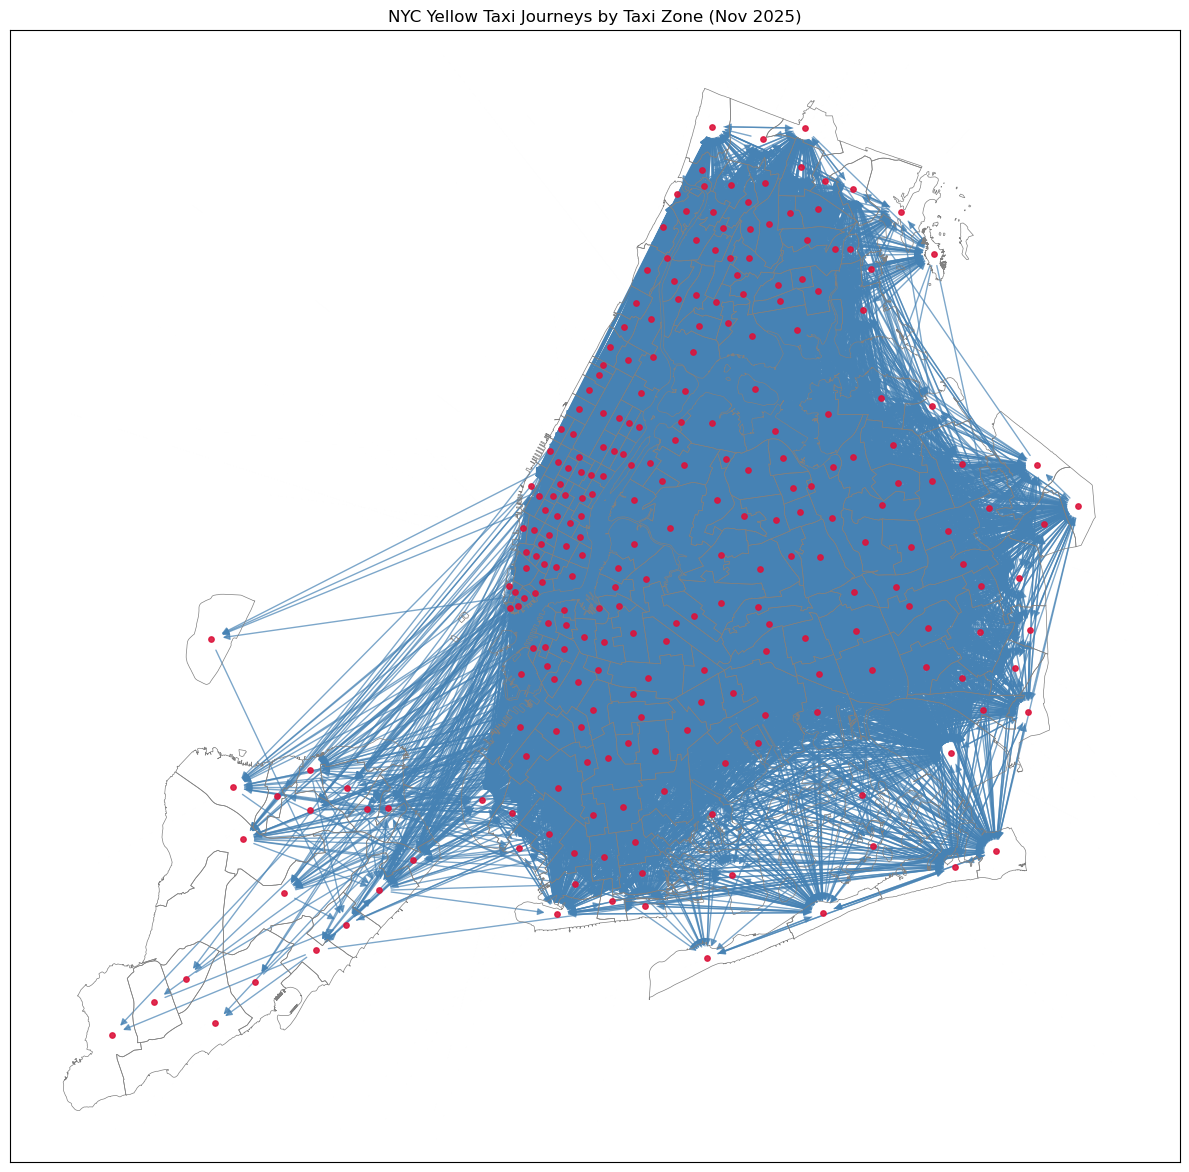

In [28]:
# Initialise figure
fig, ax = plt.subplots(figsize=(12, 12))

# Draw zone boundaries
zones.boundary.plot(ax=ax, color="gray", linewidth=0.5)
ax.set_aspect("equal")

# Draw edges first
nx.draw_networkx_edges(
    G_zones,
    pos,
    ax=ax,
    edge_color="steelblue",
    #width=widths,
    alpha=0.7
)

# Draw nodes on top
nx.draw_networkx_nodes(
    G_zones,
    pos,
    ax=ax,
    node_size=15,
    node_color="crimson",
    alpha=0.9
)

#Display graph
plt.title("NYC Yellow Taxi Journeys by Taxi Zone (Nov 2025)")
plt.tight_layout()
plt.show()

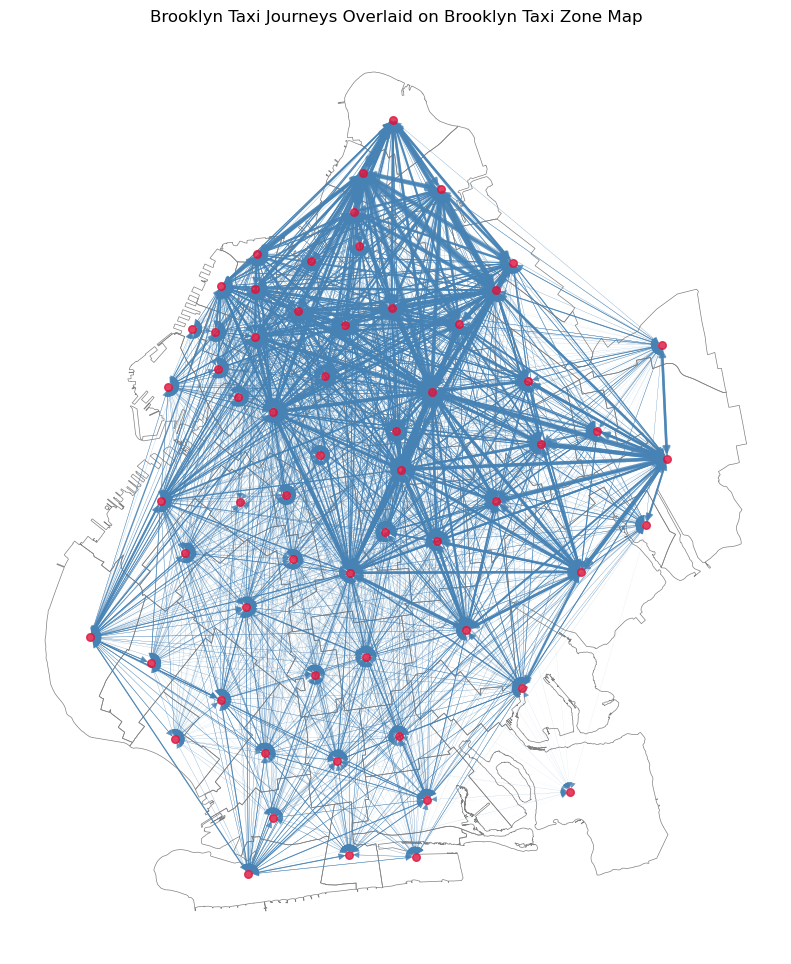

In [29]:
# Filter to Brooklyn only
brooklyn = zones[zones["borough"] == "Brooklyn"].copy()

# Reproject if needed
brooklyn = brooklyn.to_crs(epsg=2263)

# Compute centroids
brooklyn["center"] = brooklyn.geometry.centroid

# Build pos dictionary
pos = {
    int(row["objectid"]): (row["center"].x, row["center"].y)
    for _, row in brooklyn.iterrows()
}

# Filter graph to Brooklyn nodes only
G_brooklyn = G.subgraph(pos.keys()).copy()

# Plot
fig, ax = plt.subplots(figsize=(12, 12))


brooklyn.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=0.5)

nx.draw(
    G_brooklyn,
    pos,
    ax=ax,
    node_size=30,
    node_color="crimson",
    edge_color="steelblue",
    width=[G_brooklyn[u][v]["weight"] / 50 for u, v in G_brooklyn.edges()],
    arrows=True,
    alpha=0.8
)

plt.title("Brooklyn Taxi Journeys Overlaid on Brooklyn Taxi Zone Map")
plt.show()


## Chapter 5: Additional Data Manipulation and Cleaning ##

- Filter down to routes with more than x no of journeys
- Could use summary stats here

In [30]:
all_trips_filtered = all_trips[all_trips['Duration']> pd.Timedelta(180)]
print(all_trips.shape)
print(all_trips_filtered.shape)

(3563452, 7)
(3508335, 7)


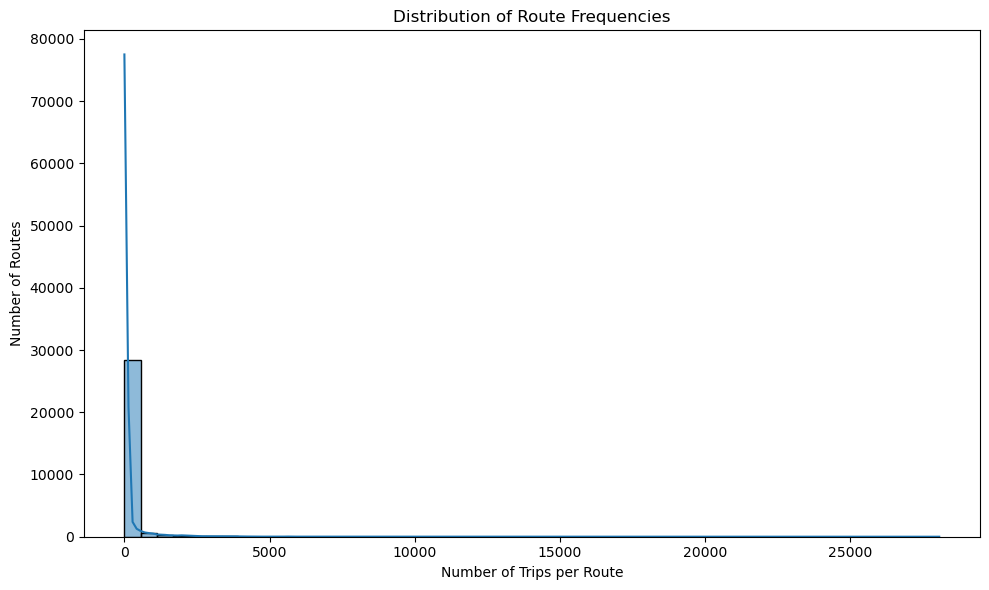

In [31]:
route_counts = (all_trips.groupby(["PULocationID", "DOLocationID"]).size().reset_index(name="count")
)

plt.figure(figsize=(10, 6))
sns.histplot(route_counts["count"], bins=50, kde=True)

plt.title("Distribution of Route Frequencies")
plt.xlabel("Number of Trips per Route")
plt.ylabel("Number of Routes")
plt.tight_layout()
plt.show()


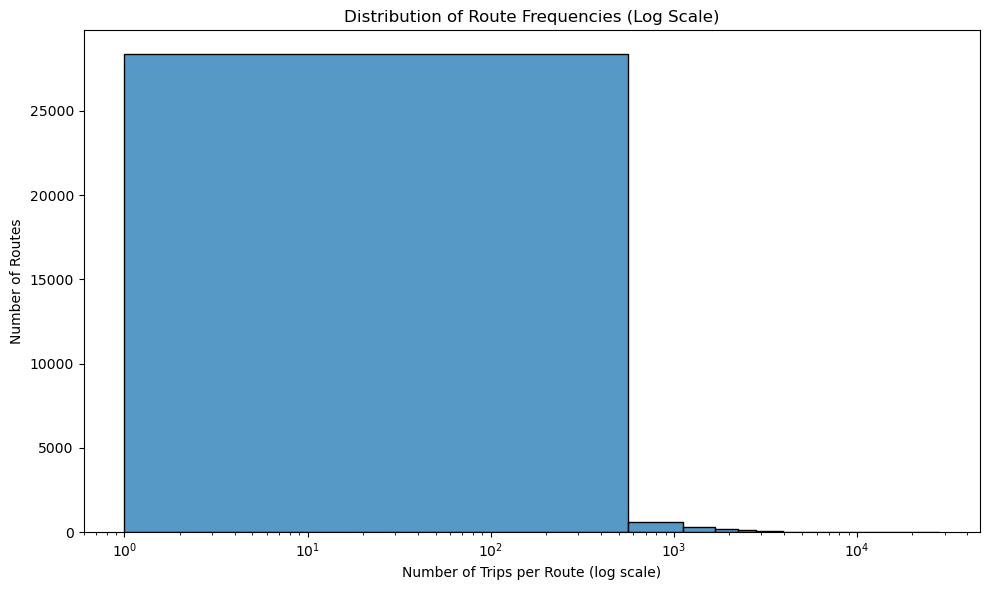

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(route_counts["count"], bins=50)
plt.xscale("log")

plt.title("Distribution of Route Frequencies (Log Scale)")
plt.xlabel("Number of Trips per Route (log scale)")
plt.ylabel("Number of Routes")
plt.tight_layout()
plt.show()


In [33]:
route_counts["count"].describe()

# Explain why you will not be filtering the data further by no. of journeys

count    29794.000000
mean       119.603007
std        586.056107
min          1.000000
25%          2.000000
50%          5.000000
75%         20.000000
max      28071.000000
Name: count, dtype: float64

## Chapter 6: Centrality Measures ##

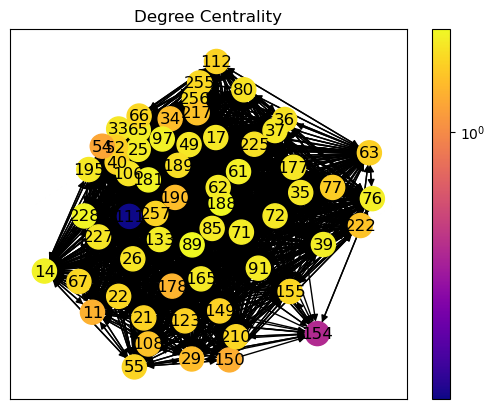

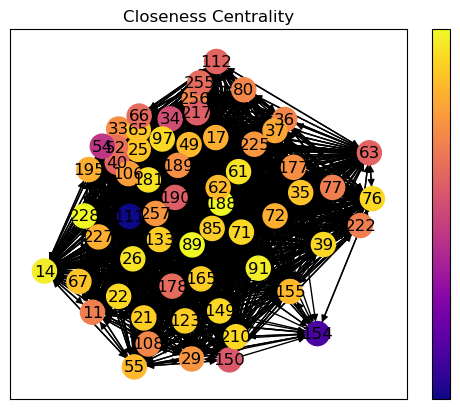

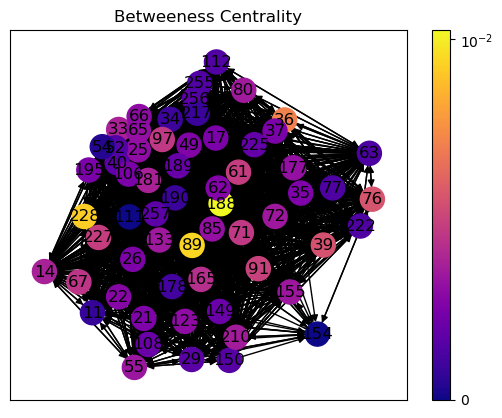

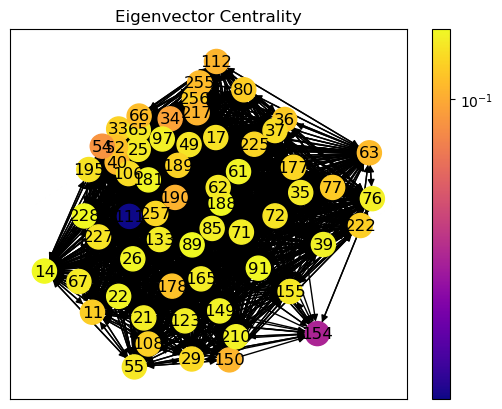

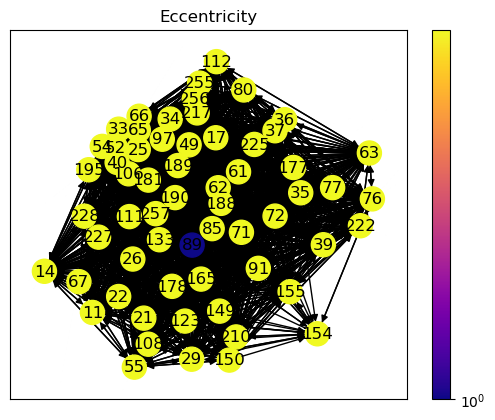

In [34]:
deg = nx.degree_centrality(G_brooklyn)
close = nx.closeness_centrality(G_brooklyn)
bet = nx.betweenness_centrality(G_brooklyn)
eig = nx.eigenvector_centrality(G_brooklyn)
ecc = nx.eccentricity(G_brooklyn)
measures = [deg,close,bet,eig,ecc]
measure_names = ['Degree Centrality','Closeness Centrality','Betweeness Centrality','Eigenvector Centrality','Eccentricity']

for i in range(len(measure_names)):  
    fig = plt.figure()
    brooklyn.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=0.5)
    nodes = nx.draw_networkx_nodes(G_brooklyn, pos,  cmap=plt.cm.plasma, 
                               node_color=list(measures[i].values()),
                               nodelist=measures[i].keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    labels = nx.draw_networkx_labels(G_brooklyn, pos)
    edges = nx.draw_networkx_edges(G_brooklyn, pos)    
    plt.title(measure_names[i])
    plt.colorbar(nodes)
   # plt.axis('off') 
    plt.show()

In [35]:

def plot_centrality_measures(G, pos, borough_gdf):
    """
    Compute and plot several centrality measures on a GeoDataFrame background.
    
    Parameters
    ----------
    G : networkx.Graph
        The graph to analyze.
    pos : dict
        Node positions for plotting.
    borough_gdf : GeoDataFrame
        GeoDataFrame containing the borough boundary for background.
    """

    # Always safe centrality measures
    deg = nx.degree_centrality(G)
    close = nx.closeness_centrality(G)
    bet = nx.betweenness_centrality(G)
    eig = nx.eigenvector_centrality(G)

    measures = [deg, close, bet, eig]
    measure_names = [
        'Degree Centrality',
        'Closeness Centrality',
        'Betweenness Centrality',
        'Eigenvector Centrality'
    ]

    # Try eccentricity only if graph is connected
    try:
        if nx.is_connected(G.to_undirected()):
            ecc = nx.eccentricity(G)
            measures.append(ecc)
            measure_names.append('Eccentricity')
    except nx.NetworkXError:
        print("⚠️ Graph is not connected — skipping eccentricity.")


    # Plot each measure
    for name, measure in zip(measure_names, measures):

        fig, ax = plt.subplots(figsize=(10, 10))

        borough_gdf.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=0.5)

        nodes = nx.draw_networkx_nodes(
            G,
            pos,
            ax=ax,
            node_color=list(measure.values()),
            nodelist=list(measure.keys()),
            cmap=plt.cm.plasma
        )

        nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))

        nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.5)
        nx.draw_networkx_labels(G, pos, ax=ax, font_size=6)

        ax.set_title(name)
        plt.colorbar(nodes, ax=ax)

        ax.set_axis_off()
        plt.tight_layout()
        plt.show()




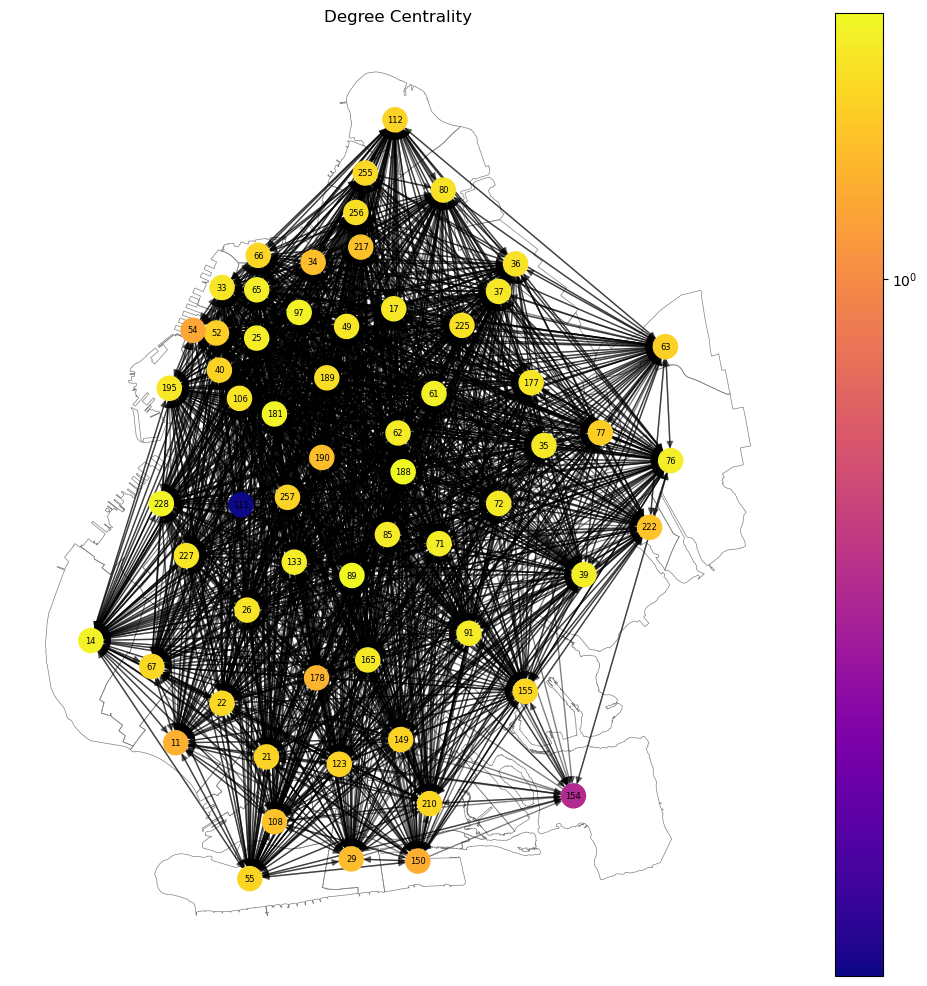

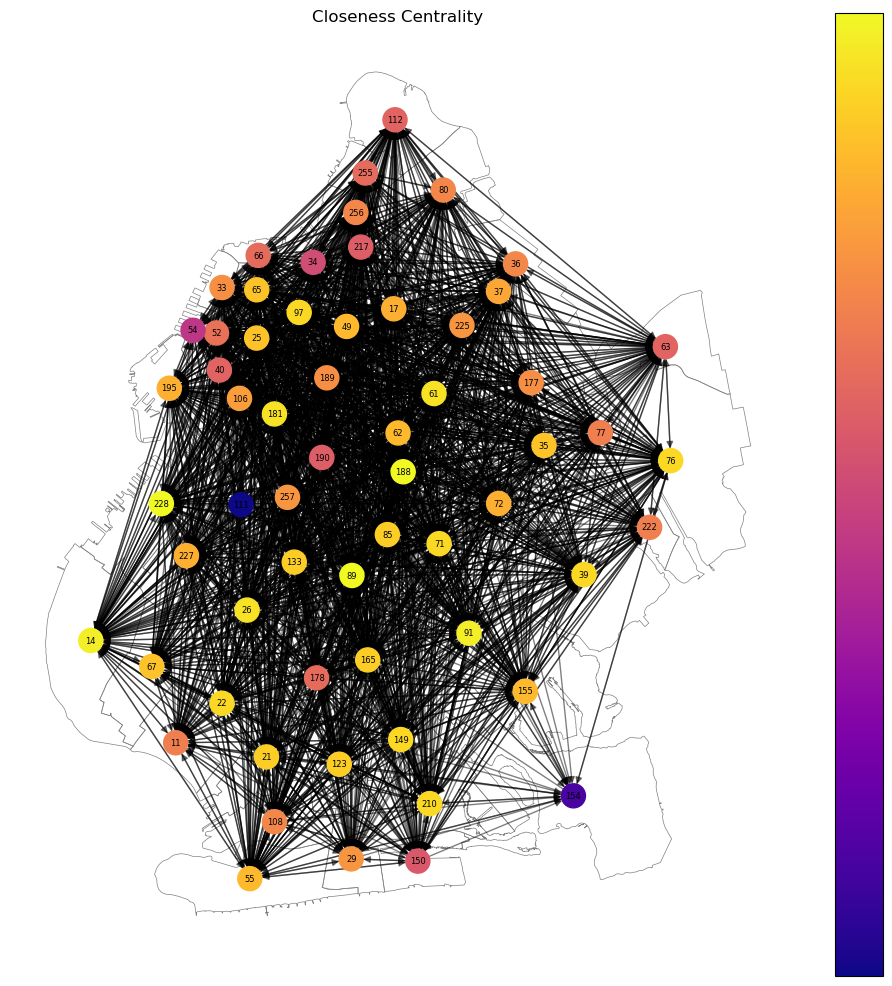

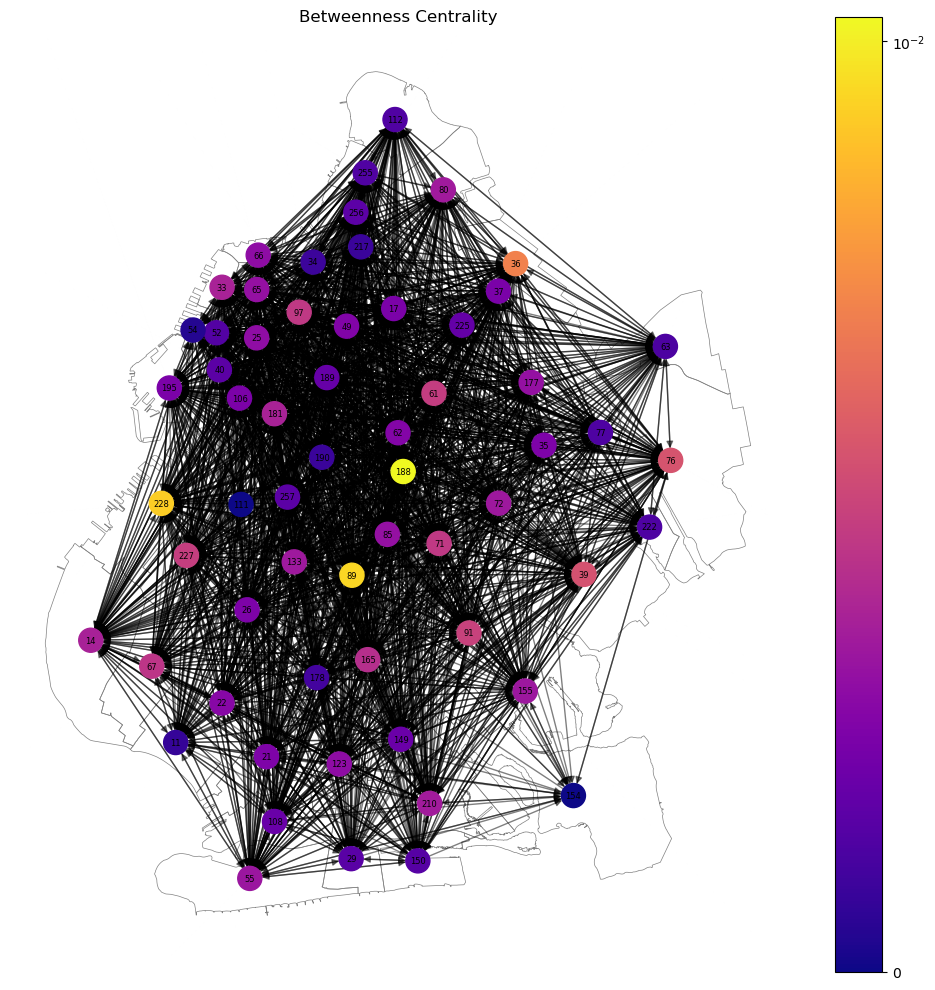

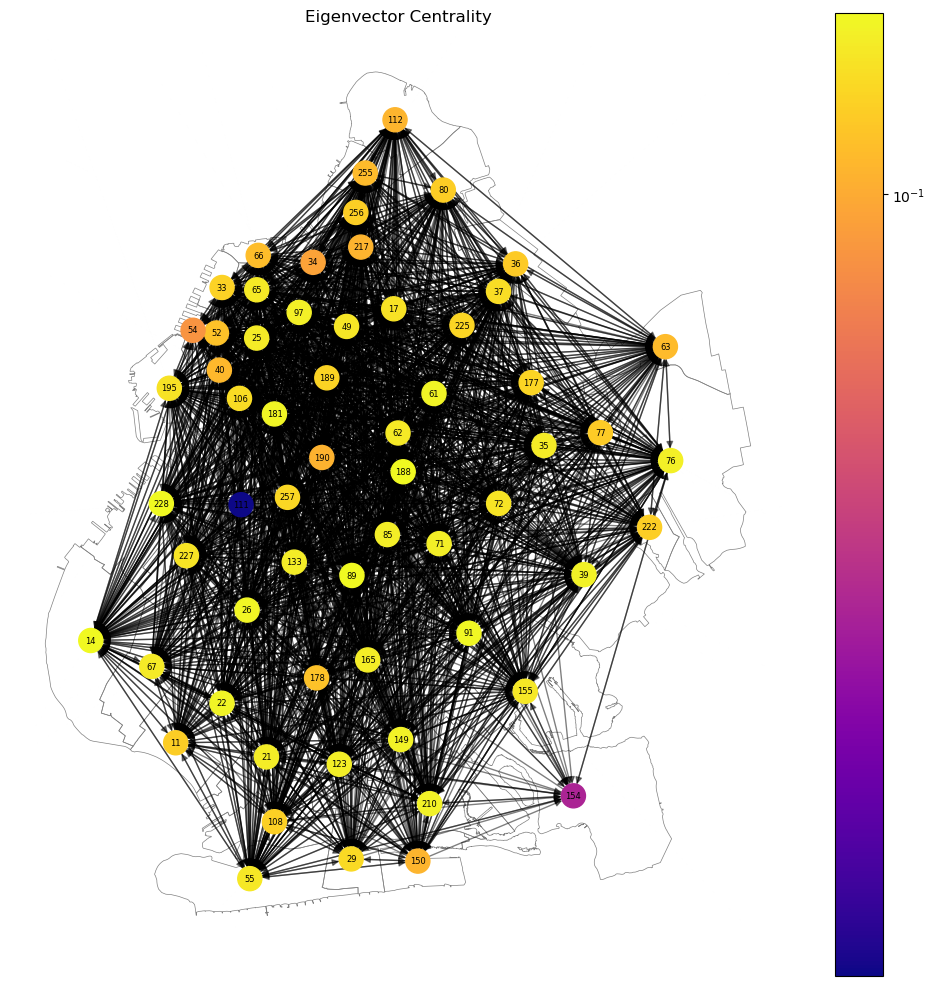

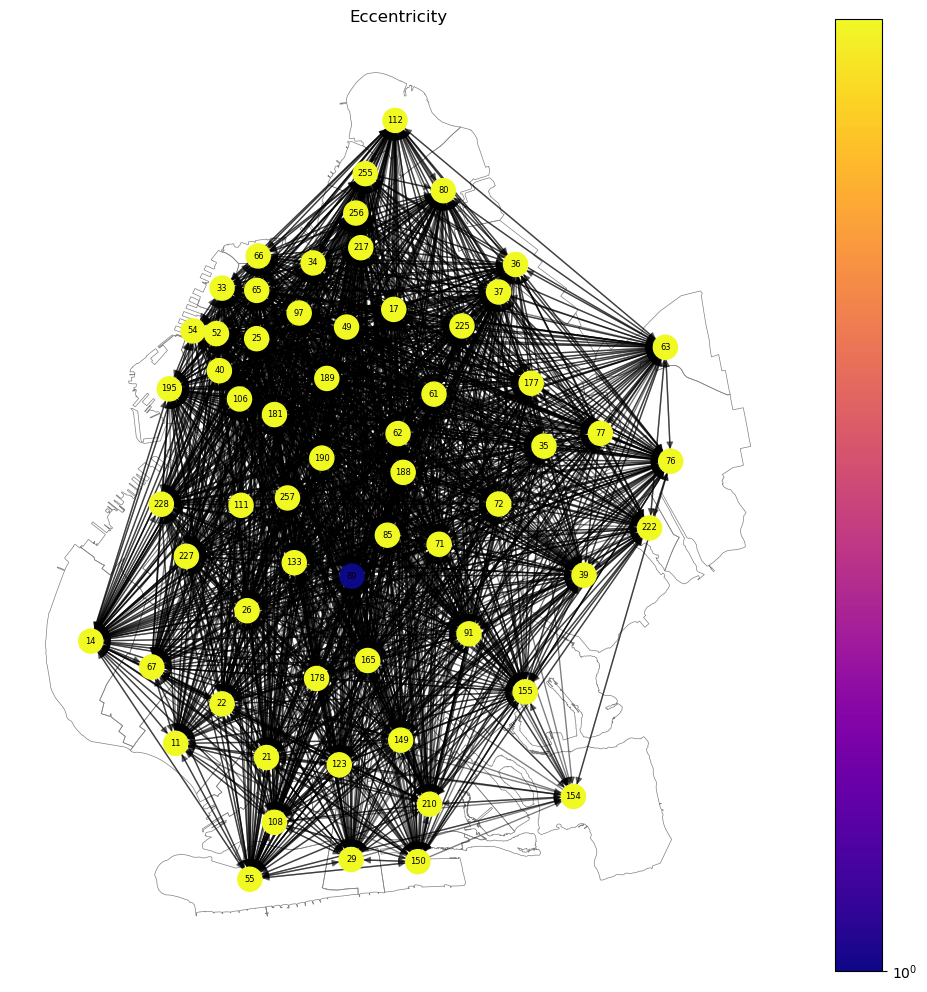

In [36]:
plot_centrality_measures(G_brooklyn, pos, brooklyn)

In [37]:
missing = [n for n in G_zones.nodes if n not in pos]
missing[:10], len(missing)

([1, 172, 2, 216, 3, 18, 20, 31, 32, 41], 197)

In [38]:
list(G_zones.nodes)[:10] 


[1, 172, 2, 216, 3, 18, 20, 31, 32, 41]

In [39]:
#len(zones)
#zones['location_id'].nunique()


In [40]:
#pos = {
#    int(row['location_id']): (row.geometry.centroid.x, row.geometry.centroid.y)
#    for idx, row in zones.iterrows()
#}


In [41]:
#valid_ids = set(zones['location_id'])
#all_trips = all_trips[
#    all_trips['PULocationID'].isin(valid_ids) &
#    all_trips['DOLocationID'].isin(valid_ids)
#]


In [42]:
#zones['location_id'].nunique(), len(zones)



In [43]:
#zones['location_id'].value_counts()[zones['location_id'].value_counts() > 1]


In [44]:
#dup_ids = zones['location_id'].value_counts()[zones['location_id'].value_counts() > 1].index
#zones[zones['location_id'].isin(dup_ids)]


In [45]:
#list(pos.keys())[:10]

⚠️ Graph is not connected — skipping eccentricity.


NetworkXError: Node 1 has no position.

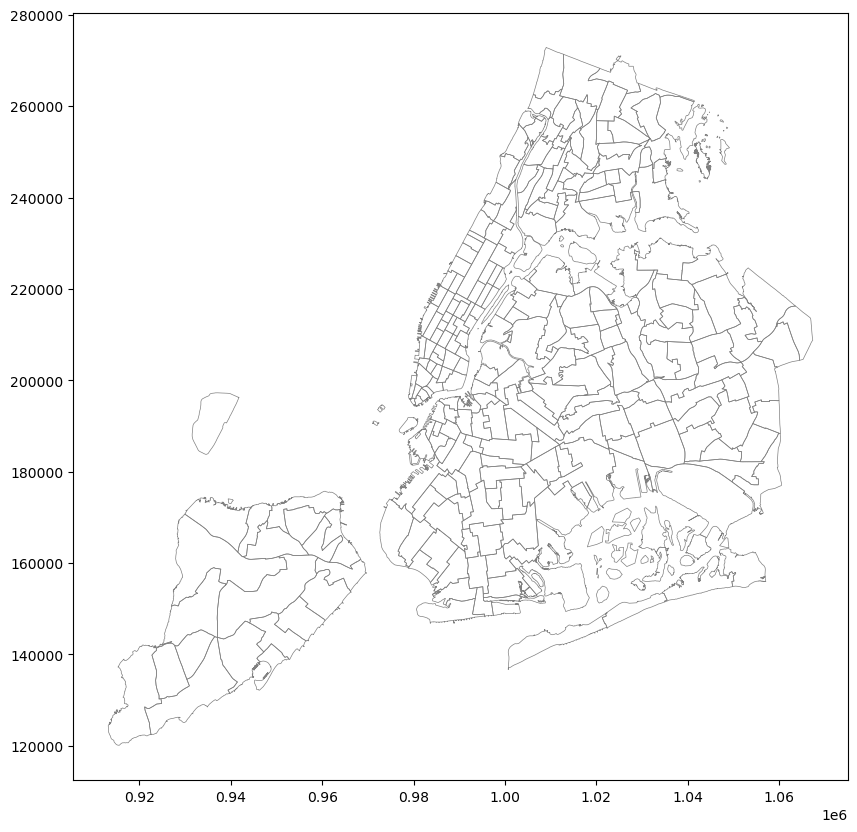

In [46]:
plot_centrality_measures(G_zones, pos, zones)

## Chapter 7: Visualisations ##

In [ ]:

def plot_centrality_measures(G, pos, borough_gdf):
    """
    Compute and plot several centrality measures on a GeoDataFrame background.
    
    Parameters
    ----------
    G : networkx.Graph
        The graph to analyze.
    pos : dict
        Node positions for plotting.
    borough_gdf : GeoDataFrame
        GeoDataFrame containing the borough boundary for background.
    """

    # Compute centrality measures
    deg = nx.degree_centrality(G)
    close = nx.closeness_centrality(G)
    bet = nx.betweenness_centrality(G)
    eig = nx.eigenvector_centrality(G)
    ecc = nx.eccentricity(G)

    measures = [deg, close, bet, eig, ecc]
    measure_names = [
        'Degree Centrality',
        'Closeness Centrality',
        'Betweenness Centrality',
        'Eigenvector Centrality',
        'Eccentricity'
    ]

    # Loop through and plot each measure
    for name, measure in zip(measure_names, measures):

        fig, ax = plt.subplots(figsize=(10, 10))

        # Plot borough boundary
        borough_gdf.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=0.5)

        # Draw nodes
        nodes = nx.draw_networkx_nodes(
            G,
            pos,
            ax=ax,
            node_color=list(measure.values()),
            nodelist=list(measure.keys()),
            cmap=plt.cm.plasma
        )

        # Symmetric log scaling for better visibility
        nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))

        # Draw edges and labels
        nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.5)
        nx.draw_networkx_labels(G, pos, ax=ax, font_size=6)

        # Title + colorbar
        ax.set_title(name)
        plt.colorbar(nodes, ax=ax)

        ax.set_axis_off()
        plt.tight_layout()
        plt.show()


## Chapter 8: Analysis ##

## Chapter 9: Conclusion ##
- Further work: Filtering by individual providers

## Chapter 9: References ##
